<Axes: >

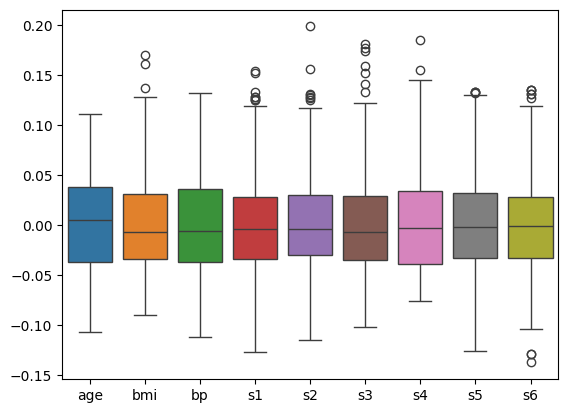

In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

X, y = datasets.load_diabetes(as_frame=True, return_X_y=True)

sns.boxplot(data=X.drop(columns='sex'))

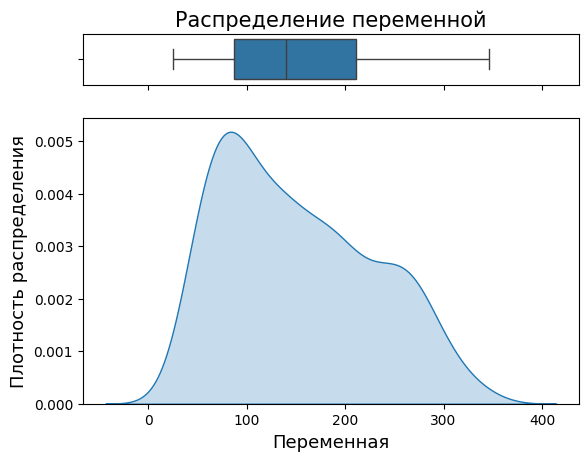

In [18]:
f, (ax_box, ax_kde) = plt.subplots(nrows = 2, # из двух строк
                                    ncols = 1, # и одного столбца
                                    sharex = True, # оставим только нижние подписи к оси x
                                    gridspec_kw = {'height_ratios': (.15, .85)}) # зададим разную высоту строк

# в первом подграфике построим boxplot
sns.boxplot(x = y, ax = ax_box)
ax_box.set(xlabel = None)
# во втором - график плотности распределения
sns.kdeplot(y, fill = True)

# зададим заголовок и подписи к осям
ax_box.set_title('Распределение переменной', fontsize = 15)
ax_kde.set_xlabel('Переменная', fontsize = 13)
ax_kde.set_ylabel('Плотность распределения', fontsize = 13)
 
plt.show()

In [3]:
data = pd.merge(X, y, left_index=True, right_index=True)

st, p = stats.pointbiserialr(X.sex, y)
print(st)

data.corr().target.to_frame().style.background_gradient()

0.04306199845160541


,target
age,0.187889
sex,0.043062
bmi,0.586450
bp,0.441482
s1,0.212022
s2,0.174054
s3,-0.394789
s4,0.430453
s5,0.565883
s6,0.382483


In [40]:
data.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [4]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest()
clf.fit(data)

data['anomaly'] = clf.predict(data)
data = data[data.anomaly == 1]
data = data.drop(columns='anomaly')
data.shape


(393, 11)

In [5]:
X = data.drop('target', axis=1)
y = data['target']

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

model = LinearRegression()
y_pred = model.fit(X, y).predict(X)

MSE = metrics.root_mean_squared_error(y, y_pred)
MAE = metrics.mean_absolute_error(y, y_pred)
MAPE = metrics.mean_absolute_percentage_error(y, y_pred)
R2 = metrics.r2_score(y, y_pred)

print(f'MSE = {MSE}\nMAE = {MAE}\nMAPE = {MAPE}\nR2 = {R2}')

MSE = 53.31120905248556
MAE = 43.10254455706237
MAPE = 0.39055981883957963
R2 = 0.4691841878649967


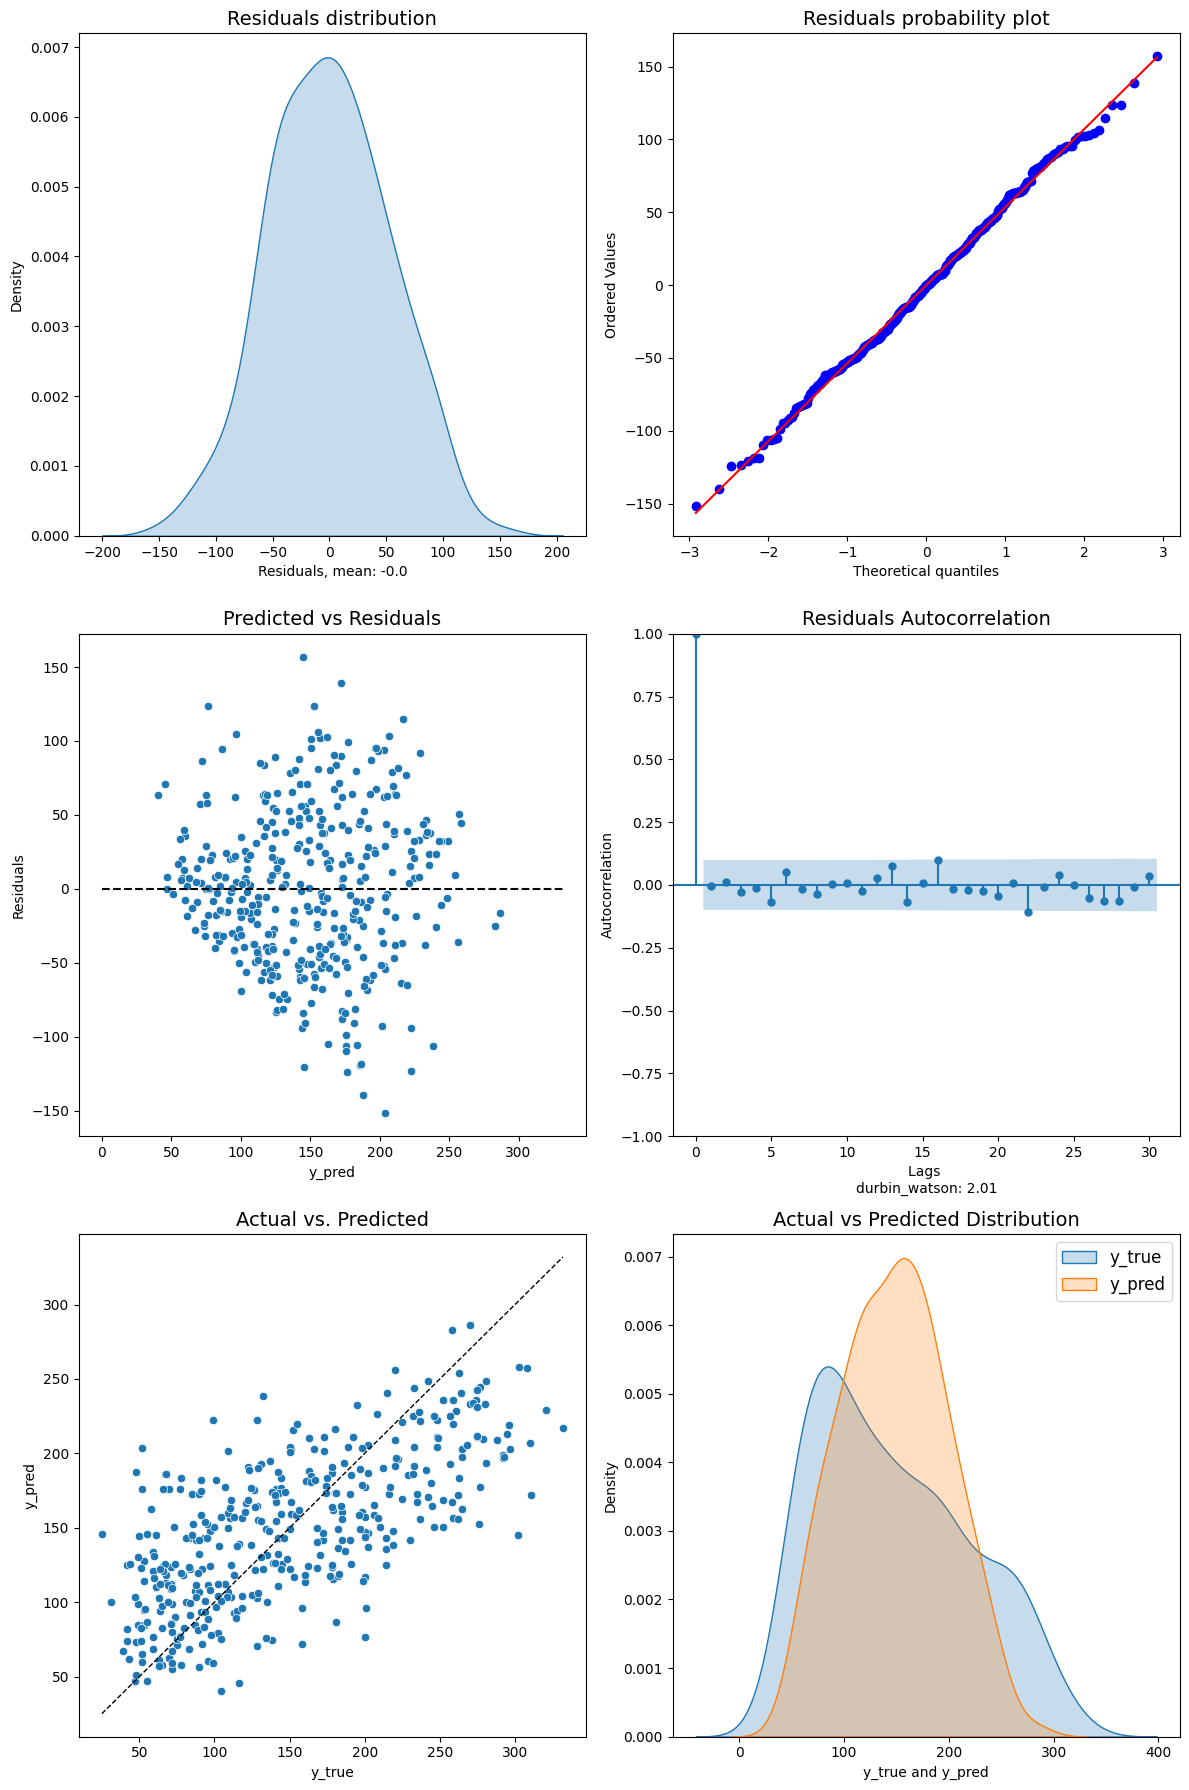

In [13]:
from user_modules.diag_LR_model import diagnostics_LR_model

diagnostics_LR_model(y, y_pred)

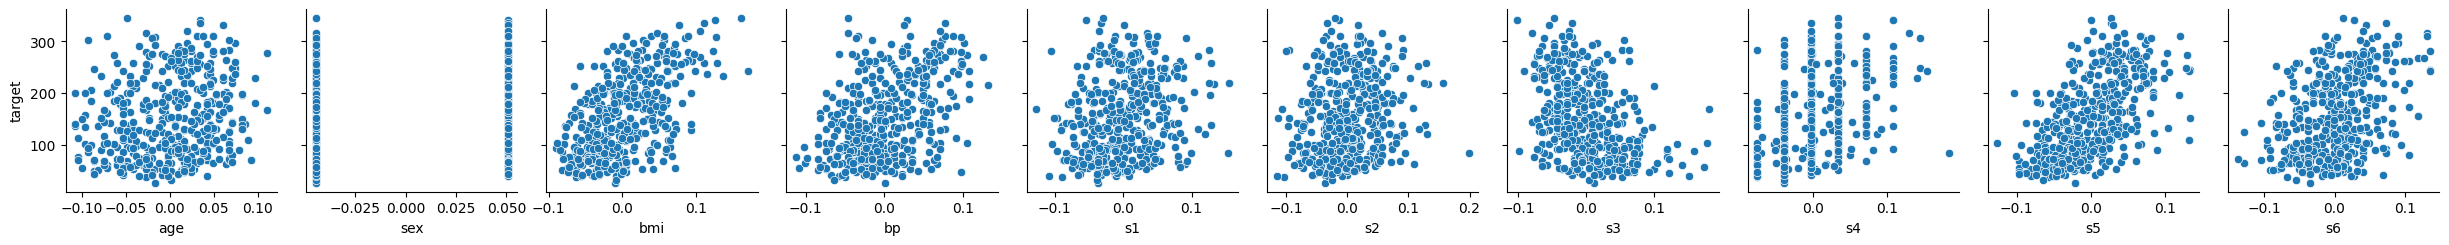

In [8]:
g = sns.PairGrid(data, x_vars=X.keys(), y_vars=['target'])
g.map(sns.scatterplot)